In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train_basic_fuzzy = pd.read_csv('train_basic_fuzzy.csv', sep=',')

In [4]:
train_basic_fuzzy.drop(['question1_form','question2_form'], axis=1, inplace=True)

In [6]:
# Check the feature values for any kind of imputation
train_basic_fuzzy.count()

is_duplicate                404290
q1_form_len                 404290
q2_form_len                 404290
q1_length                   404290
q2_length                   404290
q1_unique                   404290
q2_unique                   404290
q1_form_uni                 404290
q2_form_uni                 404290
q1_form_char                404290
q2_form_char                404290
q1_q2_char_diff             404290
common_cnt                  404290
prcnt_common                404290
partial_ratio               404290
partial_token_set_ratio     404290
partial_token_sort_ratio    404290
q_ratio                     404290
token_set_ratio             404290
token_sort_ratio            404290
w_ratio                     404290
dtype: int64

In [7]:
val_dup = train_basic_fuzzy["is_duplicate"]
train_basic_fuzzy.drop(['is_duplicate'], axis=1, inplace=True)

In [8]:
val_dup = pd.DataFrame(pd.Series(val_dup))

In [9]:
# Separate into Train and Validation
from sklearn.cross_validation import train_test_split
X_train, X_val, Y_train, Y_val = sklearn.cross_validation.train_test_split(train_basic_fuzzy, val_dup, 
                                                                           test_size = 0.2, random_state = 5)

In [15]:
# xgboost fn
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=Y_train[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(Y_train),eval_metric='auc')     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("AUC Score (Train): %f" % roc_auc_score(np.ravel(Y_train), dtrain_predprob))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [16]:
# xgboost classifier : Using the best params from the Basic Features Model
xgb1 = XGBClassifier(max_depth= 6, min_child_weight= 2,gamma=0.3, colsample_bytree=0.9, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45)

Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.836430


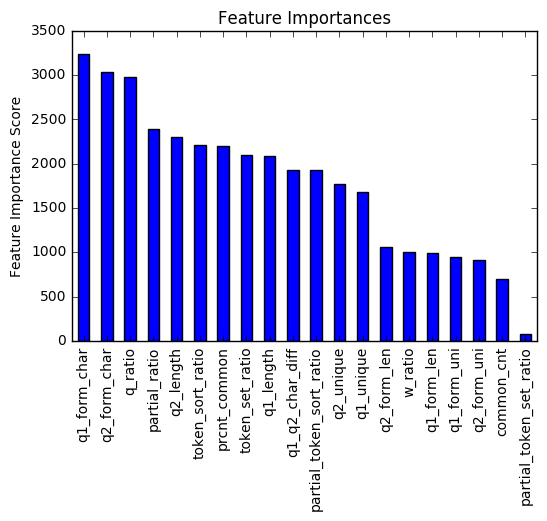

In [17]:
predictors  = list(X_train.columns)
modelfit(xgb1, X_train, predictors)

In [18]:
# Train roc auc
y_predS = xgb1.predict_proba(X_train)
roc_auc_score(Y_train, y_predS[:,1])

0.83643002509969766

In [19]:
# Cross validation AUC
cv_score = cross_val_score(xgb1, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score.mean()))
print('std auc: ' + str(cv_score.std()))

mean auc: 0.817536902394
std auc: 0.00123840355591


In [20]:
# Save the model
from sklearn.externals import joblib
joblib.dump(xgb1, '/home/pgoyal/quora/model2/xgb_dup_auc.pkl')

['/home/pgoyal/quora/model2/xgb_dup_auc.pkl',
 '/home/pgoyal/quora/model2/xgb_dup_auc.pkl_01.npy']

In [21]:
# Validation AUC
val_pred = xgb1.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred[:,1])))

Validation AUC: 0.816928566609


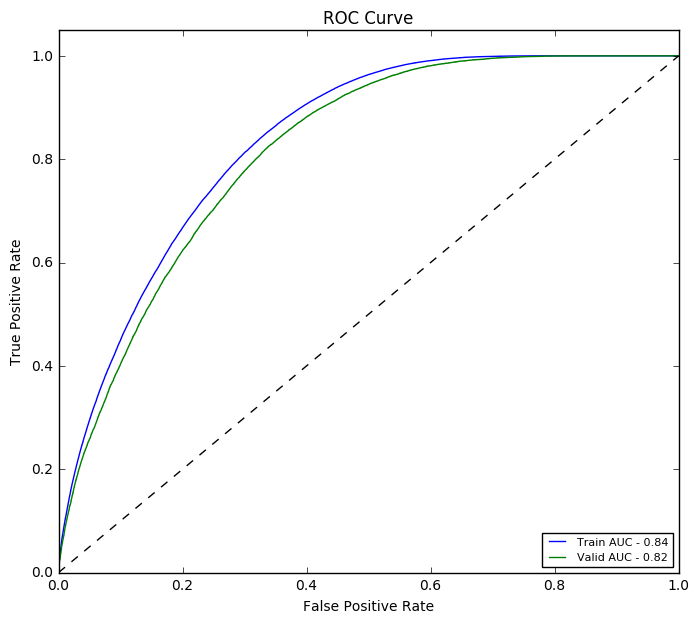

In [22]:
# Make ROC curve for train and validation
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [26]:
from sklearn import cross_validation
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV

In [27]:
# Tune tree pruning parameters: max_depth and min_child_weight
param_test1 = {
   'max_depth':[2, 3, 4, 5],
   'min_child_weight':[2, 3, 5, 6, 10]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth= 6, min_child_weight= 2,gamma=0.3, colsample_bytree=0.9, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search1.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.79646, std: 0.00115, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.79644, std: 0.00113, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.79643, std: 0.00121, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.79637, std: 0.00118, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.79655, std: 0.00123, params: {'max_depth': 2, 'min_child_weight': 10},
  mean: 0.80407, std: 0.00097, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.80410, std: 0.00101, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.80412, std: 0.00097, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.80408, std: 0.00099, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.80404, std: 0.00094, params: {'max_depth': 3, 'min_child_weight': 10},
  mean: 0.80931, std: 0.00099, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.80947, std: 0.00107, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.80938, std: 0.00098, params:

In [28]:
# Best till here : Order is on the basis of the params given!
new_max_depth = gsearch1.best_params_.values()[0]
new_min_child_weight = gsearch1.best_params_.values()[1]

In [29]:
# Tune tree pruning parameters: gamma
param_test2 = {
   'gamma':[i/10.0 for i in range(0,3)]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                     gamma=0.3, colsample_bytree=0.9, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch2.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search2.csv')
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.81393, std: 0.00106, params: {'gamma': 0.0},
  mean: 0.81390, std: 0.00096, params: {'gamma': 0.1},
  mean: 0.81383, std: 0.00110, params: {'gamma': 0.2}],
 {'gamma': 0.0},
 0.81392717029451622)

In [30]:
# Best till here :
new_gamma = gsearch2.best_params_.values()[0]

In [31]:
# Tune tree pruning parameters: subsample, colsample_bytree
param_test3 = {
  'subsample':[i/10.0 for i in range(6,9)],
 'colsample_bytree':[i/10.0 for i in range(6,9)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma ,colsample_bytree=0.9, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch3.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search3.csv')
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.81281, std: 0.00121, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.81317, std: 0.00105, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.81332, std: 0.00099, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.81324, std: 0.00115, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.81349, std: 0.00113, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.81365, std: 0.00117, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.81340, std: 0.00121, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.81374, std: 0.00112, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.81397, std: 0.00113, params: {'subsample': 0.8, 'colsample_bytree': 0.8}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.81397458501361208)

In [32]:
# Best till here :
new_subsample = gsearch3.best_params_.values()[0]
new_colsample_bytree = gsearch3.best_params_.values()[1]

In [33]:
# Tune tree pruning parameters: reg_alpha
param_test4 = {
    'reg_alpha':[ 1e-2, 0.1, 1]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma,colsample_bytree=new_colsample_bytree, subsample=new_subsample, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch4.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search4.csv')
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.81350, std: 0.00106, params: {'reg_alpha': 0.01},
  mean: 0.81367, std: 0.00113, params: {'reg_alpha': 0.1},
  mean: 0.81397, std: 0.00113, params: {'reg_alpha': 1}],
 {'reg_alpha': 1},
 0.81397458501361208)

In [34]:
# Best till here :
new_reg_alpha= gsearch4.best_params_.values()[0]

In [35]:
# Tune tree pruning parameters: reg_lambda
param_test5 = {
  'reg_lambda':[0, 1,2, 3]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch5.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search5.csv')
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.81397, std: 0.00113, params: {'reg_lambda': 0},
  mean: 0.81367, std: 0.00110, params: {'reg_lambda': 1},
  mean: 0.81358, std: 0.00103, params: {'reg_lambda': 2},
  mean: 0.81356, std: 0.00102, params: {'reg_lambda': 3}],
 {'reg_lambda': 0},
 0.81397458501361208)

In [36]:
# Best till here :
new_reg_lambda= gsearch5.best_params_.values()[0]

In [37]:
# Tune tree pruning parameters: max_delta_step
param_test6 = {
  'max_delta_step':[1,2,3]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = new_reg_lambda, max_delta_step = 3, scale_pos_weight= 2, 
                    learning_rate = 0.05, n_estimators=700, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch6.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search6.csv')
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.81331, std: 0.00103, params: {'max_delta_step': 1},
  mean: 0.81374, std: 0.00115, params: {'max_delta_step': 2},
  mean: 0.81397, std: 0.00113, params: {'max_delta_step': 3}],
 {'max_delta_step': 3},
 0.81397458501361208)

In [38]:
# Best till here :
new_max_delta_step= gsearch6.best_params_.values()[0]

In [39]:
# Tune tree pruning parameters: scale_pos_weight
param_test7 = {
  'scale_pos_weight':[1, 2, 5]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = new_reg_lambda, max_delta_step = new_max_delta_step , 
                    scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700, objective= 'binary:logistic', 
                    nthread=4, seed=45), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch7.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch7.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search7.csv')
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.81429, std: 0.00105, params: {'scale_pos_weight': 1},
  mean: 0.81397, std: 0.00113, params: {'scale_pos_weight': 2},
  mean: 0.81282, std: 0.00109, params: {'scale_pos_weight': 5}],
 {'scale_pos_weight': 1},
 0.81429191006743395)

In [40]:
# Best till here :
new_scale_pos_weight= gsearch7.best_params_.values()[0]

In [41]:
param_test8 = {
    'learning_rate':[0.03, 0.05],
    'n_estimators':[250, 500, 700]
}

gsearch8 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = new_reg_lambda, max_delta_step = new_max_delta_step , 
                    scale_pos_weight= new_scale_pos_weight, learning_rate = 0.05, n_estimators=700,
                    objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch8.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch8.grid_scores_).to_csv('/home/pgoyal/quora/model2/gs_files/gs_search8.csv')
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.80092, std: 0.00115, params: {'n_estimators': 250, 'learning_rate': 0.03},
  mean: 0.80765, std: 0.00116, params: {'n_estimators': 500, 'learning_rate': 0.03},
  mean: 0.81052, std: 0.00112, params: {'n_estimators': 700, 'learning_rate': 0.03},
  mean: 0.80602, std: 0.00103, params: {'n_estimators': 250, 'learning_rate': 0.05},
  mean: 0.81188, std: 0.00100, params: {'n_estimators': 500, 'learning_rate': 0.05},
  mean: 0.81429, std: 0.00105, params: {'n_estimators': 700, 'learning_rate': 0.05}],
 {'learning_rate': 0.05, 'n_estimators': 700},
 0.81429191006743395)

In [42]:
# Best till here :
new_learning_rate= gsearch8.best_params_.values()[0]
new_n_estimators= gsearch8.best_params_.values()[1]

In [ ]:
# Using the final param values from the above GridSearch
# Make this var in the below model call : Check!

Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.825214


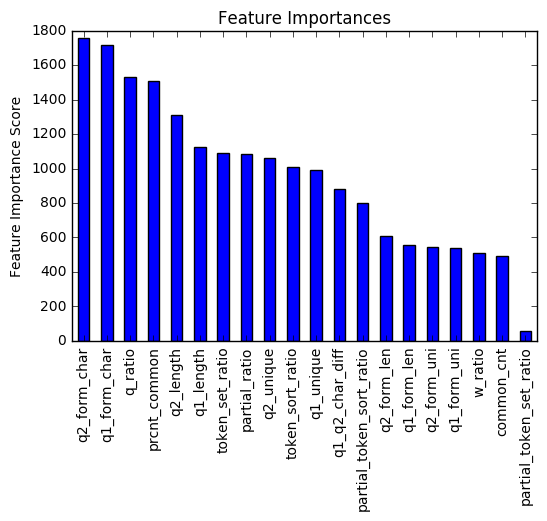

In [43]:
# Final xgboost classifier with updated params
xgb2 = XGBClassifier( max_depth= 5, min_child_weight= 2,gamma=0, colsample_bytree=0.8, subsample=0.8, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45)

#Choose the predictors for xgboost and fit the model
modelfit(xgb2, X_train, predictors)

In [44]:
# Train roc_auc
y_predS_xgb2 = xgb2.predict_proba(X_train)
roc_auc_score(Y_train, y_predS_xgb2[:,1])

0.82521384444199908

In [45]:
# Cross validation AUC 
cv_score_xgb2 = cross_val_score(xgb2, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_xgb2.mean()))
print('std auc: ' + str(cv_score_xgb2.std()))

mean auc: 0.814291910067
std auc: 0.00104837051288


In [46]:
# Save the model
from sklearn.externals import joblib
# Model-1 (without prcnt_common feature)
#joblib.dump(xgb2, '/home/pgoyal/quora/model2/xgb2_dup_auc.pkl')
# Model-2 (with prcnt_common feature)
joblib.dump(xgb2, '/home/pgoyal/quora/model2/xgb2_dup_auc_2.pkl')

['/home/pgoyal/quora/model2/xgb2_dup_auc_2.pkl',
 '/home/pgoyal/quora/model2/xgb2_dup_auc_2.pkl_01.npy']

## Decile Info - Train

In [47]:
# Decile related info

df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(y_predS_xgb2[:,1]) # y_predS is to be changed
prob.columns = ['Probability']
prob["Target"] = Y_train.values # y_train to be changed
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [48]:
# Decile info dataframe

df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,32343,25522.0,6821.0,0.213425,0.789104,0.033461,0.213425,0.033461,0.49367,2.134263
1,32343,21379.0,10964.0,0.178780,0.661009,0.053785,0.392205,0.087247,0.49367,1.961035
2,32343,19053.0,13290.0,0.159329,0.589092,0.065196,0.551533,0.152443,0.49367,1.838456
3,32343,16794.0,15549.0,0.140438,0.519247,0.076278,0.691971,0.228721,0.49367,1.729939
4,32343,14251.0,18092.0,0.119172,0.440621,0.088753,0.811144,0.317473,0.49367,1.622297
5,32343,11173.0,21170.0,0.093433,0.345453,0.103852,0.904577,0.421326,0.49367,1.507637
6,32343,7632.0,24711.0,0.063822,0.235971,0.121223,0.968399,0.542549,0.49367,1.383435
7,32343,3331.0,29012.0,0.027855,0.102990,0.142322,0.996254,0.684871,0.49367,1.245325
8,32343,446.0,31897.0,0.003730,0.013790,0.156475,0.999983,0.841347,0.49367,1.111099
9,32343,2.0,32341.0,0.000017,0.000062,0.158653,1.000000,1.000000,0.49367,1.000006


Probability from classifier for Train
Response 10%: 0.789104288409
Capture at 10%: 0.213424985157
Response 5%: 0.83612639911
Capture at 5%: 0.113067910991


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f42236c44d0>)

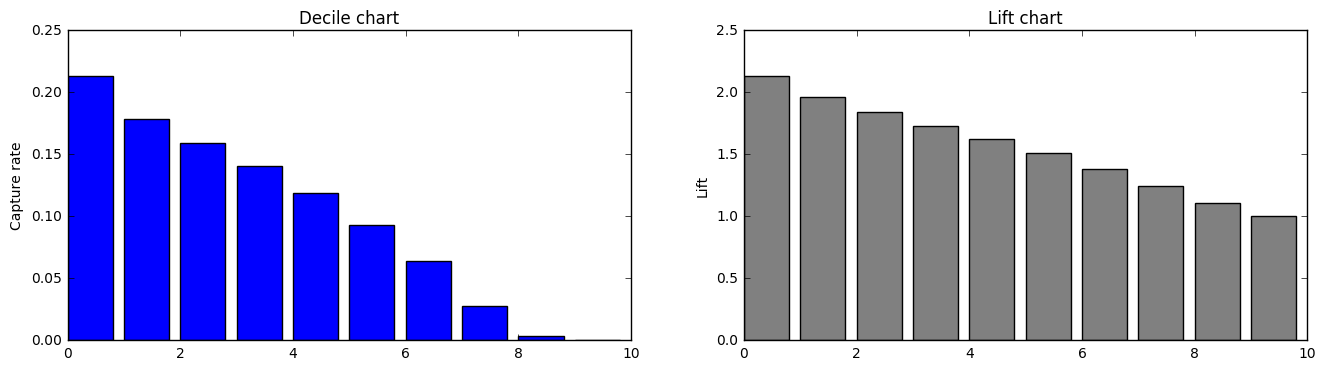

In [49]:
# Top decile, 5% capture, decile chart and lift chart
per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Train' 
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

## Decile Info - Validation

In [50]:
# Validation AUC
val_pred_xgb2 = xgb2.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred_xgb2[:,1])))

Validation AUC: 0.813157753661


In [51]:
# Decile related info
df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(val_pred_xgb2[:,1]) 
prob.columns = ['Probability']
prob["Target"] = Y_val.values 
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [52]:
# Decile info dataframe
df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,8085,6211.0,1874.0,0.209265,0.768213,0.036623,0.209265,0.036623,0.474381,2.092862
1,8085,5123.0,2962.0,0.172608,0.633643,0.057885,0.381873,0.094509,0.474381,1.909556
2,8085,4694.0,3391.0,0.158154,0.580581,0.066269,0.540027,0.160778,0.474381,1.800268
3,8085,4098.0,3987.0,0.138073,0.506865,0.077917,0.678100,0.238695,0.474381,1.695417
4,8085,3625.0,4460.0,0.122136,0.448361,0.087160,0.800236,0.325855,0.474381,1.600630
5,8085,2872.0,5213.0,0.096765,0.355226,0.101876,0.897001,0.427731,0.474381,1.495150
6,8085,1938.0,6147.0,0.065296,0.239703,0.120129,0.962298,0.547860,0.474381,1.374847
7,8085,928.0,7157.0,0.031267,0.114780,0.139867,0.993565,0.687727,0.474381,1.242079
8,8085,189.0,7896.0,0.006368,0.023377,0.154309,0.999933,0.842036,0.474381,1.111146
9,8085,2.0,8083.0,0.000067,0.000247,0.157964,1.000000,1.000000,0.474381,1.000099


Probability from classifier for Validation
Response 10%: 0.768212739641
Capture at 10%: 0.209265498652
Response 5%: 0.815685304305
Capture at 5%: 0.11108490566


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f4223277f90>)

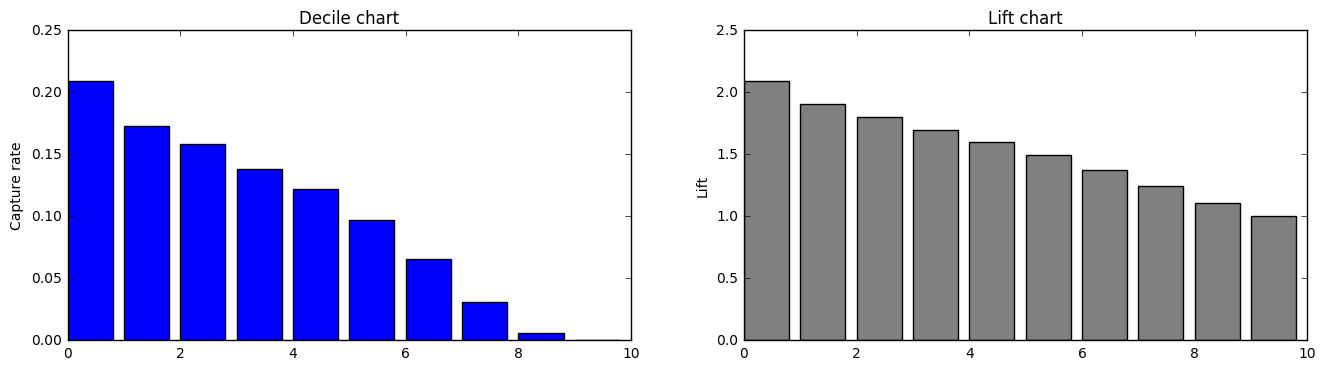

In [53]:
# Top decile, 5% capture, decile chart and lift chart

per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Validation'
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

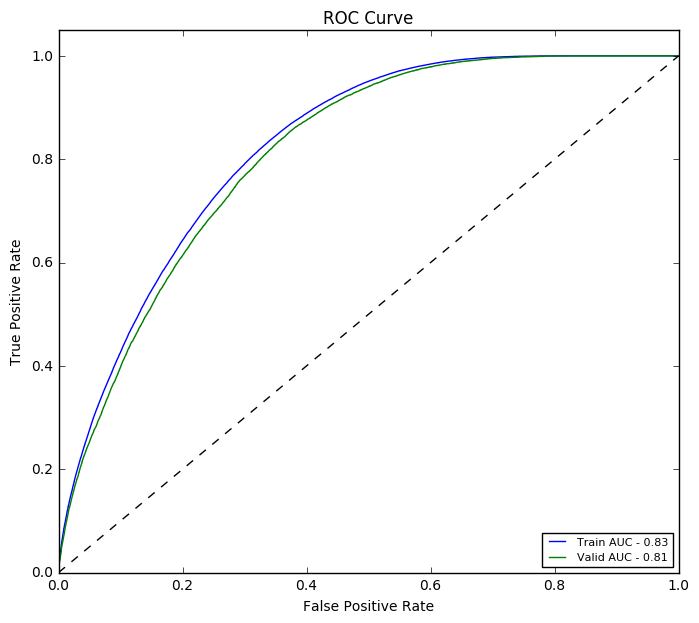

In [54]:
# Make ROC curve for train and validation as of now
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS_xgb2[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred_xgb2[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)
# print roc_auc

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)   # Valid or Test ???
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [55]:
feat_imp = pd.Series(xgb2.booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()

In [56]:
feat_imp.iloc[0:21]

,features,importance,importance_percent
0,q2_form_char,1758,0.091615
1,q1_form_char,1719,0.089583
2,q_ratio,1532,0.079837
3,prcnt_common,1508,0.078587
4,q2_length,1312,0.068373
5,q1_length,1125,0.058627
6,token_set_ratio,1091,0.056855
7,partial_ratio,1086,0.056595
8,q2_unique,1060,0.055240
9,token_sort_ratio,1009,0.052582


In [57]:
def draw_feature_importance(fea_imp_df, nb, imp_col):
    fea_imp_df = fea_imp_df.sort_values(imp_col).reset_index(drop=True)
    fea_imp_df = fea_imp_df[-1*nb:].reset_index(drop=True)

    plt.figure(figsize=(10, nb*0.3))
    plt.title("Top %d Most Important Features"%nb)
    plt.barh(fea_imp_df.index, fea_imp_df[imp_col], color='#348ABD', align="center", lw='2', edgecolor='#348ABD', alpha=0.6)
    plt.yticks(fea_imp_df.index, fea_imp_df['features'], fontsize=12,)
    plt.ylim([-1, nb])
    plt.xlim([0, fea_imp_df[imp_col].max()*1.1])
    plt.show()

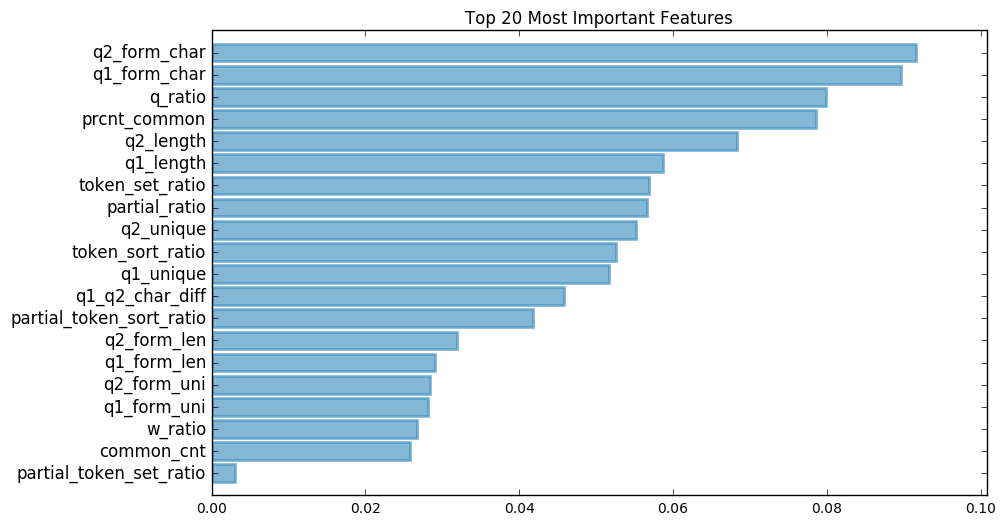

In [58]:
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

In [ ]:
# Add Extra features here : 1. TF-IDF 